<a href="https://colab.research.google.com/github/Lor3nzoVis3/DeepLearning_ProjectLV_GB/blob/master/TransferLearningV3_sourceLight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
"""
@author: LorenzoVisentini
"""

modelName = "InceptionV3"

#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#keras
import keras
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#inception v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
#Images parameters
img_width = 299
img_height = 299

# train_dir = './source_light/training'
# validation_dir = './source_light/validation' 
train_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/source_light/training'
validation_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/source_light/validation' 

batch_size = 32
epochs = 20

In [31]:
#from https://edebrouwer.github.io/deeplearning/carvision/transfer/neural/networks/learning/2017/08/05/TransferLearning.html

#Transfer learning on InceptionV3 model
#use all the layers except for the last fully connected layer (because its 
#specific to the ImageNet competition)
#we will retrain layers with new inputs
pre_trained_model = InceptionV3(input_shape = (img_height, img_width, 3),
                               include_top = False, #exclude last flatten layer
                               weights = 'imagenet' #weights from imageNet
                               ) 

# pre_trained_model.summary() #check V3 structure

In [32]:
n_classes = 3

#transfer learning phase
x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation= 'relu')(x) #add fully connected layer
x = Dropout(0.5)(x)
x = Dense(512, activation= 'relu')(x)
x = Dense(n_classes, activation= 'softmax')(x)
model = Model(inputs = pre_trained_model.input, outputs = x)

#freeze the model excepted added layers
#freeze the model excepted added layers
for layer in pre_trained_model.layers:
    layer.trainable = False

model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',  #because we have 3 possible outputs
              metrics = ['accuracy'])

In [33]:
#preprocessing
datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

val_generator = datagen.flow_from_directory(directory=validation_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

Found 7000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [34]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.n//batch_size,
                             epochs = epochs,
                             validation_data = val_generator,
                             validation_steps=val_generator.n//batch_size
                             )


Epoch 1/20
218/218 [==============================] - 127s 582ms/step - loss: 1.0350 - accuracy: 0.5161 - val_loss: 0.9979 - val_accuracy: 0.5524
Epoch 2/20
218/218 [==============================] - 120s 552ms/step - loss: 0.8797 - accuracy: 0.5751 - val_loss: 0.7281 - val_accuracy: 0.5515
Epoch 3/20
218/218 [==============================] - 121s 555ms/step - loss: 0.8613 - accuracy: 0.5792 - val_loss: 0.9512 - val_accuracy: 0.5468
Epoch 4/20
218/218 [==============================] - 120s 552ms/step - loss: 0.8567 - accuracy: 0.5809 - val_loss: 1.0261 - val_accuracy: 0.5714
Epoch 5/20
218/218 [==============================] - 120s 552ms/step - loss: 0.8526 - accuracy: 0.5798 - val_loss: 0.9744 - val_accuracy: 0.5617
Epoch 6/20
218/218 [==============================] - 120s 551ms/step - loss: 0.8630 - accuracy: 0.5690 - val_loss: 0.7899 - val_accuracy: 0.5714
Epoch 7/20
218/218 [==============================] - 121s 553ms/step - loss: 0.8505 - accuracy: 0.5695 - val_loss: 0.7223 -

In [35]:
#save model and history
file_model = '/content/drive/My Drive/Deep Learning Project - Image Classification/Models/'+ 'SourceLight' + 'Dropout' + modelName + '_' + str(batch_size) + '_' + str(epochs)
model.save(file_model + '.h5')
print(file_model)
#save history
file_hist = '/content/drive/My Drive/Deep Learning Project - Image Classification/History/'+ 'SourceLight' + 'Dropout' + modelName + '_' + str(batch_size) + '_' + str(epochs) + '.csv'
df_history = pd.DataFrame(history.history)
with open(file_hist, 'w') as file:
    df_history.to_csv(file)

/content/drive/My Drive/Deep Learning Project - Image Classification/Models/SourceLightDropoutInceptionV3_32_20


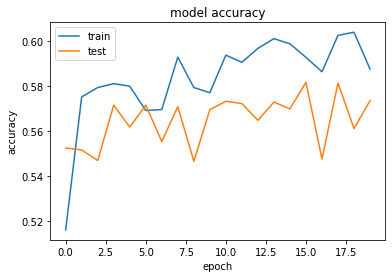

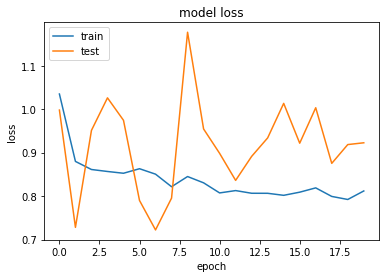

In [36]:
#plot results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
#evaluation
# https://stackoverflow.com/questions/40564936/keras-what-is-the-difference-between-model-evaluate-generator-and-model-predict
steps = val_generator.n // val_generator.batch_size

accuracy_ontest = model.evaluate_generator(val_generator, steps)
predictions_ontest = model.predict_generator(val_generator, steps)
print(accuracy_ontest)
print(predictions_ontest)

[0.8843996524810791, 0.5702285170555115]
[[0.57272303 0.18682872 0.24044827]
 [0.9332937  0.03379965 0.03290672]
 [0.33088627 0.31552404 0.35358974]
 ...
 [0.3575384  0.3011969  0.34126472]
 [0.4061261  0.27339473 0.32047915]
 [0.27184367 0.3465508  0.38160554]]
